# BPNN

This notebook implements a BPNN model on our data as is described in the report.

In [ ]:
%cd /content/drive/Shareddrives/ML\ Final\ Project
import random, time
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

gpu_name = tf.test.gpu_device_name()

/content/drive/Shareddrives/ML Final Project


Functions for running cross validation and building confusion matrices.

In [ ]:
def cv_confusion_matrix(model_gen, train_method, X, y, folds=5, epochs = 10):
    ''' Generates confusion matrix given a classifier '''
    skf = StratifiedKFold(n_splits=folds)
    cv_iter = skf.split(X, y)
    cms = np.zeros((2,2), dtype=int)

    with tf.device(gpu_name):
      for train, test in cv_iter:
          model = model_gen(X[0].shape)
          train_method(X[train], y[train], model = model, epochs = epochs, verbose_level = 0)
          cm = confusion_matrix(y[test], [0 if pred < 0.5 else 1 for pred in model.predict(X[test])])
          cms = np.add(cms, cm)

    return cms

def plot_cm(cm, title, save_name = None):
    df_cm = pd.DataFrame(cm, range(2), range(2))

    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt = 'd') # font size

    plt.title(title)
    if (save_name != None):
      plt.savefig(save_name)
    plt.show()

## BPNN Architecture

This architecture was determine partly through cross validation but also through modeling it after CNN's in the Kaggle notebooks submitted for the challenge connected to our dataset.

In [ ]:
# Builds the BPNN
def BPNN(input_shape):
  model = keras.models.Sequential()
  model.add(keras.Input(input_shape))

  # Start off with two large layers:
  model.add(keras.layers.Dense(128, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dense(128, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'))
  model.add(keras.layers.BatchNormalization())

  # Two hidden layers with 64 nodes:
  model.add(keras.layers.Dense(64, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dense(64, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'))
  model.add(keras.layers.BatchNormalization())
  
  # One more smaller hidden layer an then a singular activation layer
  model.add(keras.layers.Dense(32, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'))
  model.add(keras.layers.Dense(1, activation = 'sigmoid', kernel_initializer='random_normal', bias_initializer='zeros'))
  
  return model

blank_model = BPNN((1, 175 * 250))
print(blank_model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 1, 128)            5600128   
_________________________________________________________________
batch_normalization_48 (Batc (None, 1, 128)            512       
_________________________________________________________________
dense_73 (Dense)             (None, 1, 128)            16512     
_________________________________________________________________
batch_normalization_49 (Batc (None, 1, 128)            512       
_________________________________________________________________
dense_74 (Dense)             (None, 1, 64)             8256      
_________________________________________________________________
batch_normalization_50 (Batc (None, 1, 64)             256       
_________________________________________________________________
dense_75 (Dense)             (None, 1, 64)           

## Training Procedure

The following function trains the BPNN model with given hyperparameters.

In [ ]:
def train(Xtrain, Ytrain, model, epochs = 10, verbose_level = 1,
          learning_rate = 0.01, batch_size = 50,   
          ret_history = False):

  cweight_arr = compute_class_weight('balanced', np.unique(Ytrain), Ytrain)
  cweight = {0: cweight_arr[0], 1: cweight_arr[1]}

  metrics = ['accuracy', keras.metrics.Precision(name = 'precision'), \
                        keras.metrics.Recall(name = 'recall')]

  # Set the optimizer:
  sgd = keras.optimizers.SGD(lr = learning_rate)

  # Cost function is Cross Entropy
  model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = metrics)

  with tf.device(gpu_name):
    history = model.fit(Xtrain, Ytrain, batch_size = batch_size, epochs = epochs, 
                        shuffle = True, class_weight = cweight, 
                        verbose = verbose_level)
  
  if (ret_history):
    return model, history

  return model

## Load the Data

In the below code, I load the data from the relevant folders that include the pooled data.

In [ ]:
# Load each split:
Xtrain = np.load("xray_dataset_pooled/train_processed.npy")
Ytrain = np.load("xray_dataset_pooled/train_labels.npy")

Xtrain = np.array([Xtrain[i].ravel() for i in range(0, Xtrain.shape[0])])

Xval = np.load("xray_dataset_pooled/val_processed.npy")
Yval = np.load("xray_dataset_pooled/val_labels.npy")

Xval = np.array([Xval[i].ravel() for i in range(0, Xval.shape[0])])

Xtest = np.load("xray_dataset_pooled/test_processed.npy")
Ytest = np.load("xray_dataset_pooled/test_labels.npy")

Xtest = np.array([Xtest[i].ravel() for i in range(0, Xtest.shape[0])])

# Append all of the data together for cross validation
Xwhole = np.append(Xtrain, Xtest, axis = 0)
Xwhole = np.append(Xwhole, Xval, axis = 0)
Ywhole = np.append(Ytrain, Ytest, axis = 0)
Ywhole = np.append(Ywhole, Yval, axis = 0)

## Experimenting with Hyperparameters

The following block of code was used to analyze the the choices of different hyperparameters for the BPNN. You can change the variables at the bottom of the file to test different hyperparamters as I did on the report.


In [ ]:
# Experimenting with different learning rates

def cv_differ_parameters(model_gen, train_method, X, y, folds = 5, epochs = 10, lr = 0.001, 
                         batch_size = 32):
  skf = StratifiedKFold(n_splits=folds)
  cv_iter = skf.split(X, y)

  accuracy_per_epoch = [0] * epochs
  precision_per_epoch = [0] * epochs
  recall_per_epoch = [0] * epochs

  with tf.device(gpu_name):
    for train, test in cv_iter:
        model = model_gen(X[0].shape)
        model, history = train_method(X[train], y[train], model = model, epochs = epochs, \
                                      verbose_level = 0, learning_rate = lr, ret_history = True,
                                      batch_size = batch_size)
        accuracy_per_epoch = [accuracy_per_epoch[i] + history.history['accuracy'][i] for i in range(0, epochs)]
        precision_per_epoch = [precision_per_epoch[i] + history.history['precision'][i] for i in range(0, epochs)]
        recall_per_epoch = [recall_per_epoch[i] + history.history['recall'][i] for i in range(0, epochs)]

  # Average the values
  accuracy_per_epoch = [i / folds for i in accuracy_per_epoch] 
  precision_per_epoch = [i / folds for i in precision_per_epoch] 
  recall_per_epoch = [i / folds for i in recall_per_epoch] 

  return accuracy_per_epoch, precision_per_epoch, recall_per_epoch

# Change hyperparameters here:
lr = 0.01
epochs = 20
bs = 100

acc, pre, rec = cv_differ_parameters(BPNN, train, Xwhole, Ywhole, epochs = epochs, lr = lr, 
                                     batch_size = bs)


We then plot the convergence path for the method with the above hyperparamters:

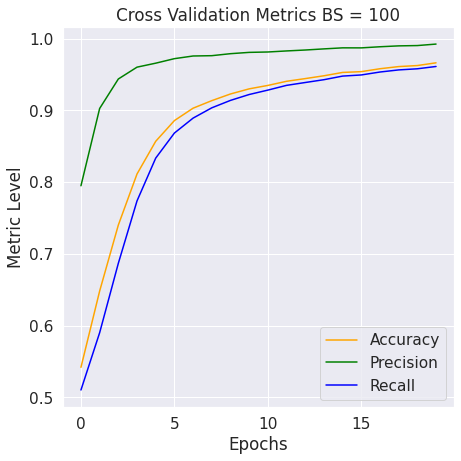

In [ ]:
eps = range(epochs)

plt.figure(figsize = (7, 7))
plt.plot(eps, acc, c = "orange", label = "Accuracy")
plt.plot(eps, pre, c = "green", label = "Precision")
plt.plot(eps, rec, c = "blue", label = "Recall")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Level")
plt.title("Cross Validation Metrics BS = {}".format(bs))
plt.savefig("BPNN/batch_size_analysis/bs={}.png".format(bs))
plt.show()

## Training for Testing Data

The below block of code trains the model on the training split to then be evaluated on the testing dataset.

In [ ]:
with tf.device(gpu_name):
  start = time.time()
  net = BPNN(Xtrain[0].shape)
  train(Xtrain, Ytrain, model = net, epochs = 20, learning_rate = 0.01, batch_size = 50)
  print("Training Time =", time.time() - start)

Epoch 1/20
105/105 [==============================] - 1s 7ms/step - loss: 0.6860 - accuracy: 0.6348 - precision: 0.8131 - recall: 0.6601
Epoch 2/20
105/105 [==============================] - 1s 6ms/step - loss: 0.6499 - accuracy: 0.7456 - precision: 0.9408 - recall: 0.7017
Epoch 3/20
105/105 [==============================] - 1s 7ms/step - loss: 0.5187 - accuracy: 0.8148 - precision: 0.9755 - recall: 0.7701
Epoch 4/20
105/105 [==============================] - 1s 7ms/step - loss: 0.3315 - accuracy: 0.8884 - precision: 0.9861 - recall: 0.8619
Epoch 5/20
105/105 [==============================] - 1s 7ms/step - loss: 0.2234 - accuracy: 0.9237 - precision: 0.9901 - recall: 0.9063
Epoch 6/20
105/105 [==============================] - 1s 7ms/step - loss: 0.1699 - accuracy: 0.9396 - precision: 0.9866 - recall: 0.9314
Epoch 7/20
105/105 [==============================] - 1s 7ms/step - loss: 0.1436 - accuracy: 0.9465 - precision: 0.9886 - recall: 0.9388
Epoch 8/20
105/105 [=====================

We then evaluate the model on the testing dataset

20/20 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.8237 - precision: 0.8125 - recall: 0.9333
Testing Time = 0.13362932205200195
[[150  84]
 [ 26 364]]


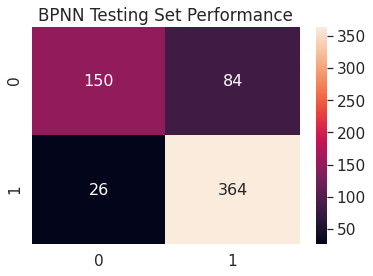

In [ ]:
net.evaluate(Xtest, Ytest)

start = time.time()
ypreds = net.predict(Xtest)
y_class_preds = [0 if pred < 0.5 else 1 for pred in ypreds]
print("Testing Time =", time.time() - start)

# Generate confusion matrix:
print(metrics.confusion_matrix(Ytest, y_class_preds))

plot_cm(metrics.confusion_matrix(Ytest, y_class_preds), "BPNN Testing Set Performance")

## Cross Validation

We then perform cross validation on the model with only the training data.

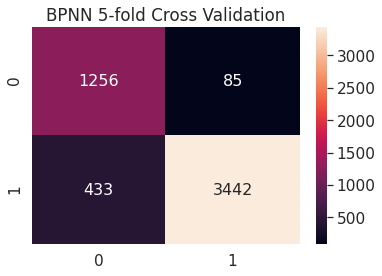

In [ ]:
# Performing 5-fold Cross Validation
cm = cv_confusion_matrix(BPNN, train, Xtrain, Ytrain, folds = 5, epochs = 20)
plot_cm(cm, title = "BPNN 5-fold Cross Validation")